# RAQ - comparing Open-weight and Closed-source models

### Import Libraries

In [1]:
import os
import csv
from time import sleep
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import utils

from dotenv import load_dotenv
from datasets import load_dataset
from generator import Generator

load_dotenv('env/var.env')


True

## Define models

### Open-weight models

In [2]:
llama2_70b = Generator(model='meta/llama2-70b', api_key=os.getenv("NGC_API_KEY"))

yi = Generator(model='01-ai/yi-large', api_key=os.getenv("NGC_API_KEY"))

dbrx = Generator(model='databricks/dbrx-instruct', api_key=os.getenv("NGC_API_KEY"))

gemma_7b = Generator(model='google/gemma-7b', api_key=os.getenv("NGC_API_KEY"))

mistral7b = Generator(model="mistralai/mistral-7b-instruct-v0.3", api_key=os.getenv("NGC_API_KEY"))

mixtral8x7b = Generator(model='mistralai/mixtral-8x7b-instruct-v0.1', api_key=os.getenv("NGC_API_KEY"))

mixtral8x22b = Generator(model='mistralai/mixtral-8x22b-instruct-v0.1', api_key=os.getenv("NGC_API_KEY"))

llama3_70b = Generator(model='meta/llama3-70b-instruct', api_key=os.getenv("NGC_API_KEY"))

llama3_1_70b = Generator(model='meta/llama-3.1-70b-instruct', api_key=os.getenv("NGC_API_KEY"))

llama3_1_405b = Generator(model='meta/llama-3.1-405b-instruct', api_key=os.getenv("NGC_API_KEY"))

### Closed-source models

In [3]:
gpt_3_5_turbo = Generator(model="gpt-3.5-turbo", api_key=os.getenv("OPENAI_KEY"))

gpt_4_turbo = Generator(model="gpt-4-turbo", api_key=os.getenv("OPENAI_KEY"))

claude_3_5_sonnet = Generator(model="claude-3-5-sonnet-20240620", api_key=os.getenv("ANTHROPIC_KEY"))

claude_3_oppus = Generator(model="claude-3-opus-20240229", api_key=os.getenv("ANTHROPIC_KEY"))

gemini_1_5_flash = Generator(model="gemini-1.5-flash-001", api_key=os.getenv("GEMINI_KEY"))

gemini_1_0_pro = Generator(model="gemini-1.0-pro", api_key=os.getenv("GEMINI_KEY"))

### Define the names of the models

In [2]:
models = [
    "llama2_70b", "yi", "dbrx", "gemma_7b",
    "mistral7b", "mixtral8x7b", "mixtral8x22b",
    "llama3_70b", "llama3_1_70b", "llama3_1_405b",
    "gpt_3_5_turbo", "gpt_4_turbo",
    "claude_3_5_sonnet", "claude_3_oppus",
    "gemini_1_5_flash", "gemini_1_0_pro",
]

### Load Q&A Data 

In [5]:
squad = load_dataset("squad", split="train")
squad = squad.shuffle()

### Create dictionary to save metrics

In [3]:
metrics = {}

for model in models:
    metrics[f"{model}_metrics"] = {
        "rank": [],
    }
    
for model in models:
    globals()[f"{model}_metrics"] = metrics[f"{model}_metrics"]

### Create CSV file to save the answers

In [7]:
csv_file = "model_answers.csv"
headers = models + ['correct_answer']

with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=headers)
    writer.writeheader()

### Gather answers from the models

In [ ]:
for i in range(320):
    context = squad[i]['context']
    query = squad[i]['question']
    answer = squad[i]['answers']['text'][0]

    llm_answers_dict = {"correct_answer": answer}
    
    for model in models:
        try:
            llm_response = utils.get_llm_response(eval(model), context, query)
        except:
            llm_response = " "
        llm_answers_dict[model] = llm_response
        
        # Timeout for the gemini 1.5 model
        if i % 15 == 0:
            sleep(30)
        
    with open(csv_file, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=headers)
        writer.writerow(llm_answers_dict)

### Rank the models based on the answers

In [4]:
csv_file = "model_answers.csv"
df = pd.read_csv(csv_file)

for index, row in df.iterrows():
    csv_dict = row.to_dict()
    answer = csv_dict.pop("correct_answer")
    
    rank = utils.get_gpt_rank(answer, csv_dict, os.getenv("OPENAI_KEY"))

    for idx, model in enumerate(models):
        rank_value = rank[model]
        metrics[f"{model}_metrics"]["rank"].append(rank_value)

### Metrics aggregation

In [12]:
df = pd.DataFrame({key.replace('_metrics', ''): value['rank'] for key, value in metrics.items()})
num_open_columns = 10
open_df = df.iloc[:, :num_open_columns]
closed_df = df.iloc[:, num_open_columns:]

open_avg = open_df.mean()
closed_avg = closed_df.mean() 

In [ ]:
data_open = {
    'Date_open': pd.to_datetime([
        '2023-07-18', '2024-06-16', '2024-03-27', '2024-02-21', 
        '2023-09-27', '2023-12-11', '2024-4-17', '2024-04-18',
        '2024-07-23', '2024-07-23'
    ]),
    'Model Open': open_avg.index.tolist(),
    'Model Open Rank': open_avg[:].tolist(),
}
data_closed = {
    'Date_closed': pd.to_datetime([
        '2023-11-06', '2023-11-06', '2024-06-20', 
        '2024-03-04', '2024-05-24', '2024-02-15'
    ]),
    'Model Closed': closed_avg.index.tolist(),
    'Model Closed Rank': closed_avg[:].tolist()
}
df_open = pd.DataFrame(data_open)
df_closed = pd.DataFrame(data_closed)

### Graph analysis

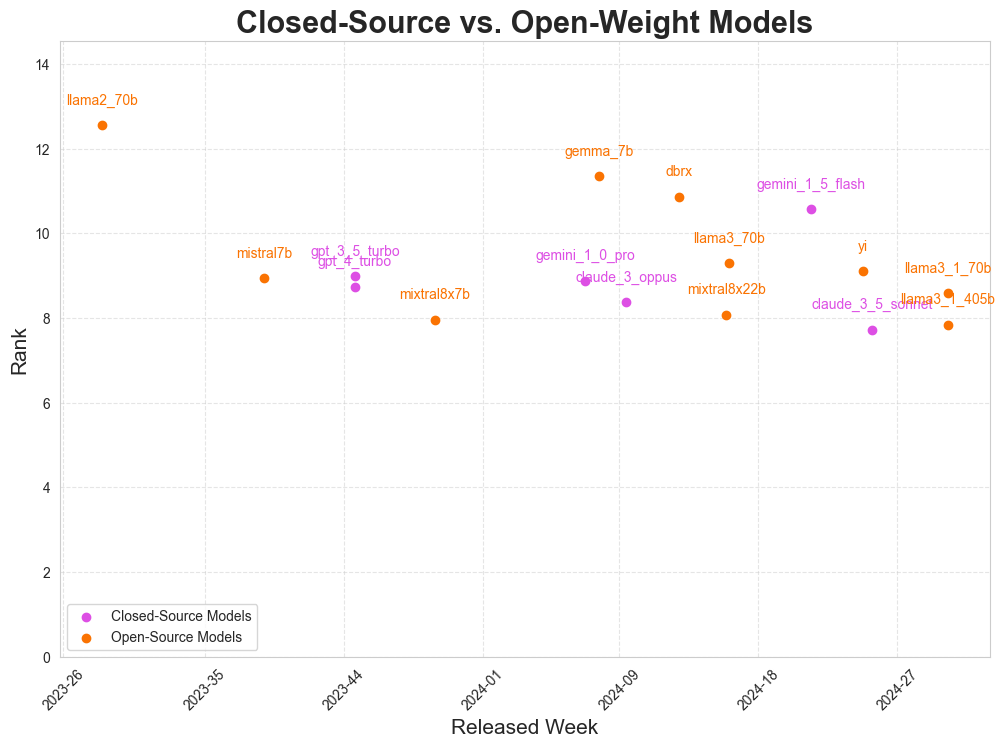

In [95]:
df_closed_sorted = df_closed.sort_values(by='Model Closed Rank')
df_open_sorted = df_open.sort_values(by='Model Open Rank')

plt.figure(figsize=(12, 8))

# Plot Closed-Source Data
plt.scatter(df_closed_sorted['Date_closed'], df_closed_sorted['Model Closed Rank'], color='#DD4FE4', label='Closed-Source Models')
for i in range(len(df_closed_sorted)):
    plt.text(df_closed_sorted['Date_closed'].iloc[i], df_closed_sorted['Model Closed Rank'].iloc[i] + 0.5, df_closed_sorted['Model Closed'].iloc[i], ha='center', color='#DD4FE4')

# Plot Open-Weight Data
plt.scatter(df_open_sorted['Date_open'], df_open_sorted['Model Open Rank'], color='#FA7302', label='Open-Source Models')
for i in range(len(df_open_sorted)):
    plt.text(df_open_sorted['Date_open'].iloc[i], df_open_sorted['Model Open Rank'].iloc[i] + 0.5, df_open_sorted['Model Open'].iloc[i], ha='center', color='#FA7302')

# Adding Titles and Labels
plt.title('Closed-Source vs. Open-Weight Models', fontsize=22, fontweight='bold')
plt.xlabel('Released Week', fontsize=15)
plt.ylabel('Rank', fontsize=15)
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.5)

ax = plt.gca()  # Get current axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%W'))  # Format dates as YYYY-WW

# Customizing the x-axis for better readability
plt.xticks(rotation=45)
plt.ylim(0, max(df_open_sorted['Model Open Rank'].max(), df_closed_sorted['Model Closed Rank'].max()) + 2)

plt.show()

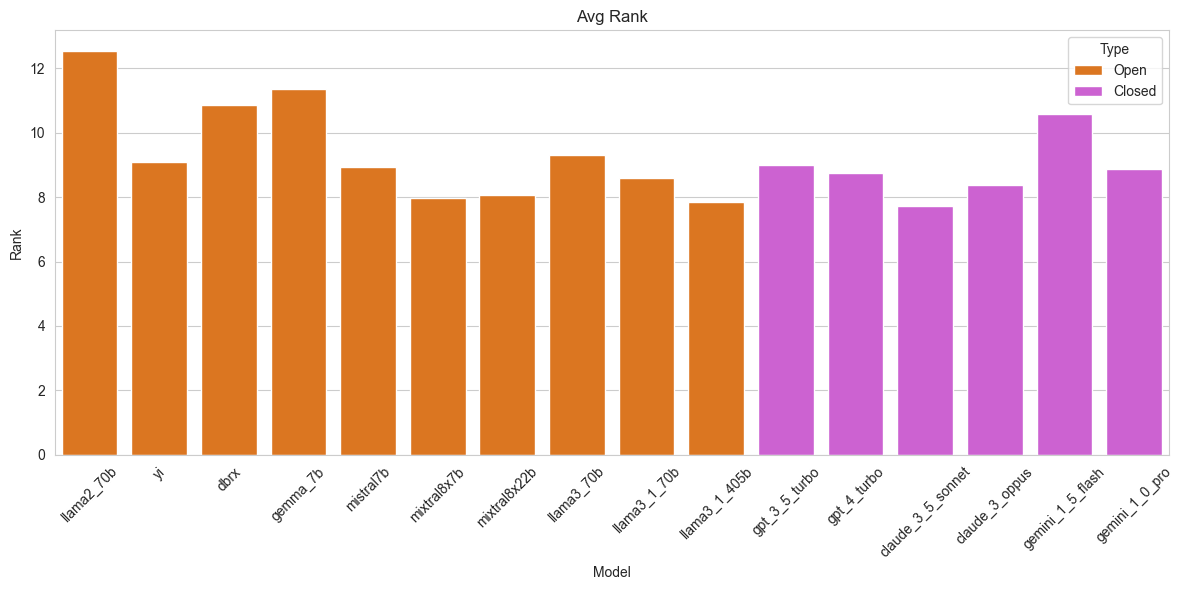

In [96]:
df_open['Type'] = 'Open'
df_closed['Type'] = 'Closed'

df_combined = pd.concat([
    df_open.rename(columns={'Model Open': 'Model', 'Model Open Rank': 'Rank'}), 
    df_closed.rename(columns={'Model Closed': 'Model', 'Model Closed Rank': 'Rank'})
])

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(ax=ax, data=df_combined, x='Model', y='Rank', hue='Type', palette=["#fa7302","#dd4fe4"])

ax.set_title("Avg Rank")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()